### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torchvision
import copy
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

### Load MNIST Data

### Prepare Dataset Splits

In [2]:
# define torch transforms to apply to data
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])

def get_mnist_data_subset(index: int, new_index: int, train: bool):
    if train:
        dataset = torchvision.datasets.MNIST(".", download=False, transform=transforms)
    else:
        dataset = torchvision.datasets.MNIST(".", download=False, train=False, transform=transforms)
    indices = torch.where(dataset.targets==index)
    return torch.utils.data.Subset(dataset, indices[0])

In [3]:
mnist_train_0 = get_mnist_data_subset(index=0, new_index=0, train=True)
mnist_train_1 = get_mnist_data_subset(index=1, new_index=1, train=True)
mnist_train_2 = get_mnist_data_subset(index=2, new_index=0, train=True)
mnist_train_3 = get_mnist_data_subset(index=3, new_index=1, train=True)

mnist_test_0 = get_mnist_data_subset(index=0, new_index=0, train=False)
mnist_test_1 = get_mnist_data_subset(index=1, new_index=1, train=False)
mnist_test_2 = get_mnist_data_subset(index=2, new_index=0, train=False)
mnist_test_3 = get_mnist_data_subset(index=3, new_index=1, train=False)

task_1_train_dataset = torch.utils.data.ConcatDataset([mnist_train_0, mnist_train_1])
task_2_train_dataset = torch.utils.data.ConcatDataset([mnist_train_2, mnist_train_3])

task_1_test_dataset = torch.utils.data.ConcatDataset([mnist_test_0, mnist_test_1])
task_2_test_dataset = torch.utils.data.ConcatDataset([mnist_test_2, mnist_test_3])

task_1_train_dataloader = torch.utils.data.DataLoader(task_1_train_dataset, batch_size=32, shuffle=True)
task_2_train_dataloader = torch.utils.data.DataLoader(task_2_train_dataset, batch_size=32, shuffle=True)
task_1_test_dataloader = torch.utils.data.DataLoader(task_1_test_dataset, batch_size=len(task_1_test_dataset))
task_2_test_dataloader = torch.utils.data.DataLoader(task_2_test_dataset, batch_size=len(task_2_test_dataset))

### Construct Model

In [4]:
class ConvNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 12)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 32, 3, 3)
        self.fc1 = nn.Linear(512, 100)
        
        self.head_1 = nn.Linear(100, 1)
        self.head_2 = nn.Linear(100, 1)
        
        self.switch_head(1)
        
    def switch_head(self, head_index):
        if head_index == 1:
            for param in self.head_2.parameters():
                param.requires_grad = False
            for param in self.head_1.parameters():
                param.requires_grad = True
            self.head = self.head_1
        elif head_index == 2:
            for param in self.head_1.parameters():
                param.requires_grad = False
            for param in self.head_2.parameters():
                param.requires_grad = True
            self.head = self.head_2
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        y = self.head(x).squeeze()
        return y

### Define Optimiser, Loss etc.

In [5]:
model = ConvNetwork()

In [6]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

In [7]:
loss = nn.BCEWithLogitsLoss()

### Train Model

In [ ]:
train_losses = []

test_losses_1 = []
test_losses_2 = []

test_accuracies_1 = []
test_accuracies_2 = []

test_data_1 = next(iter(task_1_test_dataloader))
test_data_2 = next(iter(task_2_test_dataloader))

def test_loop(current_head: int):
    model.switch_head(1)
    test_prediction_1 = model(test_data_1[0])
    test_loss_1 = loss(test_prediction_1, test_data_1[1].float())
    test_losses_1.append(test_loss_1.item())
    softmaxes_1 = torch.sigmoid(test_prediction_1)
    correct_1 = torch.where((softmaxes_1 > 0.5) == test_data_1[1])
    accuracy_1 = len(correct_1[0]) / len(test_data_1[1])
    test_accuracies_1.append(accuracy_1)
    
    model.switch_head(2)
    test_prediction_2 = model(test_data_2[0])
    mapped_labels = test_data_2[1] - 2
    test_loss_2 = loss(test_prediction_2, mapped_labels.float())
    test_losses_2.append(test_loss_2.item())
    softmaxes_2 = torch.sigmoid(test_prediction_2)
    correct_2 = torch.where((softmaxes_2 > 0.5) == mapped_labels)
    accuracy_2 = len(correct_2[0]) / len(mapped_labels)
    test_accuracies_2.append(accuracy_2)
    
    model.switch_head(current_head)

    
model.switch_head(1)    
for i in range(15):
    
    with torch.no_grad():
        test_loop(1)
    
    epoch_loss = 0
    
    for i_batch, batch in enumerate(task_1_train_dataloader):
        data = batch[0]
        label = batch[1].float()
        optimiser.zero_grad()
        model_prediction = model(data)
        train_loss = loss(model_prediction, label)
        train_loss.backward()
        optimiser.step()
        
        epoch_loss += train_loss.item()
        
    print(f"Epoch loss after epoch {i}: {epoch_loss}")
        
    train_losses.append(epoch_loss)
    
        
# switch task
model.switch_head(2)
for i in range(25):
    
    with torch.no_grad():
        test_loop(2)
    
    epoch_loss = 0
    
    for i_batch, batch in enumerate(task_2_train_dataloader):
        data = batch[0]
        label = batch[1].float() - 2
        optimiser.zero_grad()
        model_prediction = model(data)
        train_loss = loss(model_prediction, label)
        train_loss.backward()
        optimiser.step()
        
        epoch_loss += train_loss.item()
        
    print(f"Epoch loss after epoch {i}: {epoch_loss}")
        
    train_losses.append(epoch_loss)

Epoch loss after epoch 0: 30.216560775545076
Epoch loss after epoch 1: 1.9425925383220601
Epoch loss after epoch 2: 1.117923109966796
Epoch loss after epoch 3: 1.0080243739557773
Epoch loss after epoch 4: 0.9938377593512087
Epoch loss after epoch 5: 0.9251353771969661
Epoch loss after epoch 6: 0.6250067523142206
Epoch loss after epoch 7: 0.43265140227833854
Epoch loss after epoch 8: 0.2187669278454223
Epoch loss after epoch 9: 0.5407381032096623
Epoch loss after epoch 10: 0.2503912466656857
Epoch loss after epoch 11: 0.16439424844244854
Epoch loss after epoch 12: 0.2757568345749064


In [14]:
def smooth(data, bin_width: int):
    smoothed_data = []
    for i in range(len(data)):
        data_bin = data[max(0, i-bin_width):i]
        bin_average = np.mean(data_bin)
        smoothed_data.append(bin_average)
        
    return smoothed_data

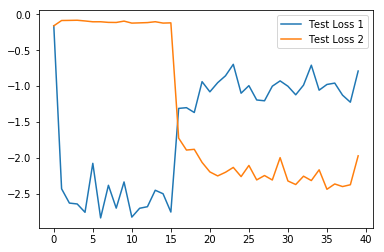

In [15]:
fig = plt.figure()
plt.plot(range(len(test_losses_1)), np.log10(test_losses_1), label="Test Loss 1")
plt.plot(range(len(test_losses_2)), np.log10(test_losses_2), label="Test Loss 2")
plt.legend()
fig.show()

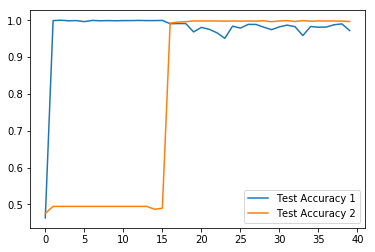

In [16]:
fig = plt.figure()
plt.plot(range(len(test_accuracies_1)), test_accuracies_1, label="Test Accuracy 1")
plt.plot(range(len(test_accuracies_2)), test_accuracies_2, label="Test Accuracy 2")
plt.legend()
fig.show()

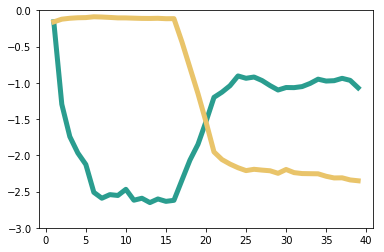

In [48]:
fig = plt.figure()
plt.plot(range(len(test_losses_1)), smooth(np.log10(test_losses_1), 5), label="Test Loss 1", linewidth=5, color="#2A9D8F")
plt.plot(range(len(test_losses_2)), smooth(np.log10(test_losses_2), 5), label="Test Loss 2", linewidth=5, color="#E9C46A")
# plt.legend()
# plt.xlim(0, 40)
plt.ylim(-3, 0)
fig.show()
fig.savefig("MNIST_forgetting_example.pdf")

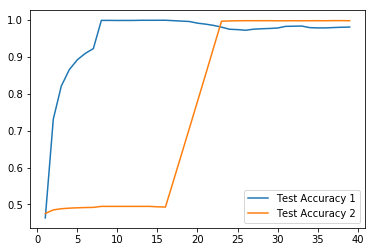

In [18]:
fig = plt.figure()
plt.plot(range(len(test_accuracies_1)), smooth(test_accuracies_1, 7), label="Test Accuracy 1")
plt.plot(range(len(test_accuracies_2)), smooth(test_accuracies_2, 7), label="Test Accuracy 2")
plt.legend()
fig.show()